# LeR with Custom Functions and Parameters

This notebook is created by [Phurailatpam Hemantakumar](https://hemantaph.com)

[![Documentation](https://img.shields.io/badge/ler-documentation-blue)](https://ler.hemantaph.com)

This notebook demonstrates how to customize the `LeR` class by defining custom source priors, lens parameter samplers, and detection criteria. We'll simulate both unlensed and lensed binary neutron star (BNS) events with fully custom configurations, then compare the results with default models.

## Table of Contents
- [1. Custom Function Definitions](#1-custom-function-definitions)
   - [1.1 Custom Source Priors](#11-custom-source-priors)
   - [1.2 Custom Lens Parameter Samplers](#12-custom-lens-parameter-samplers)
   - [1.3 Custom Detection Criteria](#13-custom-detection-criteria)
- [2. Initialize LeR with Custom Functions](#2-initialize-ler-with-custom-functions)
   - [2.1 LeR Initialization](#21-ler-initialization)
   - [2.2 Simulate Unlensed Population](#22-simulate-unlensed-population)
   - [2.3 Simulate Lensed Population](#23-simulate-lensed-population)
   - [2.4 Calculate Rates](#24-calculate-rates)
- [3. Compare Custom vs Default Models](#3-compare-custom-vs-default-models)
   - [3.1 Mass Distribution Comparison](#31-mass-distribution-comparison)
   - [3.2 Axis-Ratio Distribution Comparison](#32-axis-ratio-distribution-comparison)

---

## 1. Custom Function Definitions

The `ler` package allows full customization of sampling functions and detection criteria. This section demonstrates a **Binary Neutron Star (BNS)** configuration with custom settings:

| Component | Custom Configuration | Default (BBH) |
| :--- | :--- | :--- |
| **Event Type** | BNS (non-spinning) | BBH (spinning, aligned) |
| **Merger Rate** | Madau-Dickinson (2014) | GWTC-4 based |
| **Source Masses** | Uniform 1.0-2.3 $M_{\odot}$ | Bimodal Gaussian |
| **Lens Model** | SIE (Singular Isothermal) | EPL+Shear |
| **Velocity Dispersion** | $\sigma_* = 161$ km/s | $\sigma_* = 113.78$ km/s |
| **Axis Ratio** | Padilla & Strauss (2008) | Rayleigh distribution |
| **Detectors** | 3G (ET, CE), SNR > 12 | O4 (H1, L1, V1), SNR > 10 |

### 1.1 Custom Source Priors

Define custom merger rate density and source frame mass functions for BNS events.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ler import LeR
from ler.utils import FunctionConditioning, redshift_optimal_spacing, plots as lerplt
from ler.lens_galaxy_population import velocity_dispersion_ewoud_denisty_function
from gwsnr import GWSNR
from scipy.interpolate import CubicSpline

Using `event_type='BNS'` in the LeR class initialization will default to the following settings that include GW parameter priors corresponding to BNS. Other allowed event types are 'BBH' and 'NSBH'.

```python
    merger_rate_density_prior = "merger_rate_density_bbh_oguri2018"
    
    source_frame_masses_prior = "binary_masses_BNS_bimodal"
    merger_rate_density_prior_params = dict(
        R0=105.5 * 1e-9, b2=1.6, b3=2.1, b4=30
    )
    source_frame_masses_prior_params = dict(
        w=0.643,
        muL=1.352,
        sigmaL=0.08,
        muR=1.88,
        sigmaR=0.3,
        mmin=1.0,
        mmax=2.3,
    )
```

For our example we will modify the default priors or the prior specific parameters.

#### Merger Rate Density and Custom Mass Distribution

In [18]:
# Custom merger rate density function
merger_rate_density_function = 'merger_rate_density_madau_dickinson2014'
merger_rate_density_input_args = dict(
    R0=105.5 * 1e-9, a=0.015, b=2.7, c=2.9, d=5.6
)

# Custom source frame masses (uniform distribution for BNS)
source_frame_masses_args = dict(mmin=1.0, mmax=2.3)

def source_frame_masses_uniform(size, mmin=1.0, mmax=2.3):
    """Sample mass1 and mass2 uniformly from [mmin, mmax]."""
    mass_1_source = np.random.uniform(mmin, mmax, size)
    mass_2_source = np.random.uniform(mmin, mmax, size)
    # Ensure mass_1 >= mass_2
    idx = mass_2_source > mass_1_source
    mass_1_source[idx], mass_2_source[idx] = mass_2_source[idx], mass_1_source[idx]
    return (mass_1_source, mass_2_source)

### 1.2 Custom Lens Parameter Samplers

Define velocity dispersion and axis ratio samplers using `FunctionConditioning`. This enables fast Numba-compiled sampling via cubic spline interpolation.

In [19]:
# Custom velocity dispersion (Öguri et al. 2018 with sigma_star = 161 km/s)
velocity_dispersion_args = dict(
    sigma_min=100, sigma_max=400, alpha=0.94, beta=1.85,
    phistar=2.099e-2, sigmastar=161.0,
)

identifier_dict = {"name": "velocity_dispersion_custom"}
identifier_dict.update({
    "sigma_min": velocity_dispersion_args["sigma_min"],
    "sigma_max": velocity_dispersion_args["sigma_max"],
    "resolution": 500, "zl_resolution": 48,
})

sigma_array = np.linspace(
    identifier_dict["sigma_min"], identifier_dict["sigma_max"],
    identifier_dict["resolution"],
)
zl_array = redshift_optimal_spacing(0.001, 10.0, identifier_dict["zl_resolution"])

number_density_function = lambda sigma, zl: velocity_dispersion_ewoud_denisty_function(
    sigma, zl, alpha=velocity_dispersion_args["alpha"],
    beta=velocity_dispersion_args["beta"],
    phistar=velocity_dispersion_args["phistar"],
    sigmastar=velocity_dispersion_args["sigmastar"],
)

sigma_object = FunctionConditioning(
    function=number_density_function,
    x_array=sigma_array, conditioned_y_array=zl_array,
    identifier_dict=identifier_dict,
    directory="./interpolator_json", sub_directory="velocity_dispersion",
    name=identifier_dict["name"],
    create_new=False, create_function_inverse=False,
    create_function=True, create_pdf=True, create_rvs=True,
    callback="rvs",
)

In [ ]:
# Custom axis ratio (Padilla & Strauss 2008 distribution)
axis_ratio_args = dict(q_min=0.2, q_max=1.0)

# Pre-computed Padilla & Strauss 2008 distribution
q_array = np.array([0.04903276402927845,0.09210526315789469,0.13596491228070173,0.20789473684210524,
    0.2899703729522482,0.3230132450331126,0.35350877192982455,0.37946148483792264,
    0.4219298245614036,0.4689525967235971,0.5075026141512723,0.5226472638550018,
    0.5640350877192983,0.6096491228070177,0.6500000000000001,0.6864848379226213,
    0.7377192982456142,0.7787295224817011,0.8007581038689441,0.822786685256187,
    0.8668438480306729,0.8973684210526317,0.9254385964912283,])
pdf_array = np.array([0.04185262687135349,0.06114520695141845,0.096997499638376,0.1932510900336828,
    0.39547914337673706,0.49569751276216234,0.6154609137685201,0.7182049959882812,
    0.920153741243567,1.1573982157399754,1.3353263628106684,1.413149656448315,
    1.5790713532948977,1.7280185150744938,1.8132994441344819,1.8365803753840484,
    1.8178662203211204,1.748929843583365,1.688182592496342,1.6274353414093188,
    1.4948487090314488,1.402785526832393,1.321844068356993,])

spline = CubicSpline(q_array, pdf_array, extrapolate=True)
q = np.linspace(axis_ratio_args["q_min"], axis_ratio_args["q_max"], 500)
pdf = spline(q)

identifier_dict = {"name": "axis_ratio_padilla_strauss_custom"}
identifier_dict.update({"q_min": axis_ratio_args["q_min"], "q_max": axis_ratio_args["q_max"], "resolution": 500})

q_object = FunctionConditioning(
    function=pdf, x_array=q, conditioned_y_array=None,
    identifier_dict=identifier_dict,
    directory="./interpolator_json", sub_directory="axis_ratio",
    name="axis_ratio_padilla_strauss",
    create_new=False, create_function_inverse=False,
    create_function=True, create_pdf=True, create_rvs=True,
    callback="rvs",
)

### 1.3 Custom Detection Criteria

Define a custom pdet_finder using 3G detectors (Einstein Telescope and Cosmic Explorer) with SNR threshold of 12.

In [21]:
# 3G detectors: Einstein Telescope (ET) and Cosmic Explorer (CE)
mmin, mmax = 1.0, 2.3
zmin, zmax = 0.0, 10.0

gwsnr_3g = GWSNR(
    npool=4,
    ifos=['ET', 'CE'],  # 3G detector network
    snr_method='interpolation_no_spins',  # BNS have no spins
    mtot_min=2*mmin*(1+zmin), mtot_max=2*mmax*(1+zmax),
    sampling_frequency=2048.0, waveform_approximant='IMRPhenomD',
    minimum_frequency=20.0, gwsnr_verbose=False,
)

def detection_criteria(gw_param_dict, detection_threshold=12):
    """Custom detection criteria for 3G detectors with SNR > 12."""
    dict_ = {}
    dict_.update(gwsnr_3g.optimal_snr(gw_param_dict=gw_param_dict))
    dict_['pdet_net'] = dict_['optimal_snr_net'] > detection_threshold
    return dict_

---

## 2. Initialize LeR with Custom Functions

### 2.1 LeR Initialization

Create a `LeR` instance with custom source priors, lens samplers, and detection criteria for BNS events.

In [22]:
ler = LeR(
    # Core setup
    npool=6, event_type='BNS', lens_type='sie_galaxy',
    
    # Source priors
    source_priors=dict(
        merger_rate_density=merger_rate_density_function,
        source_frame_masses=source_frame_masses_uniform,
    ),
    source_priors_params=dict(
        merger_rate_density_input_args=merger_rate_density_input_args,
        source_frame_masses=source_frame_masses_args,
    ),
    
    # Lens samplers
    lens_param_samplers=dict(
        velocity_dispersion=sigma_object,
        axis_ratio=q_object,
    ),
    lens_param_samplers_params=dict(
        velocity_dispersion=velocity_dispersion_args,
        axis_ratio=axis_ratio_args,
    ),
    
    # Custom detection
    pdet_finder=detection_criteria,
    ler_directory='./ler_data_custom',
)

### 2.2 Simulate Unlensed Population

Generate unlensed BNS events using the custom mass distribution and merger rate density.

In [ ]:
unlensed_params = ler.unlensed_cbc_statistics(size=100000, batch_size=50000, resume=True)

print(f"Total unlensed events simulated: {len(unlensed_params['zs'])}")
print(f"Sample source redshift values (first 5): {unlensed_params['zs'][:5]}")
print(f"Sample masses (first 3):")
print(f"  mass_1: {unlensed_params['mass_1_source'][:3]}")
print(f"  mass_2: {unlensed_params['mass_2_source'][:3]}")

### 2.3 Simulate Lensed Population

Generate lensed BNS events with custom lens parameters.

In [ ]:
lensed_params = ler.lensed_cbc_statistics(size=100000, batch_size=50000, resume=True)

print(f"Total lensed events simulated: {len(lensed_params['zs'])}")
print(f"Sample source redshift values (first 5): {lensed_params['zs'][:5]}")
print(f"\nLens parameters (first 3):")
lens_params = ['zl', 'sigma', 'q']
for param in lens_params:
    if param in lensed_params:
        print(f"  {param}: {lensed_params[param][:3]}")

### 2.4 Calculate Rates

Calculate unlensed and lensed detection rates using the custom detection criteria.

In [ ]:
# Calculate detection rates
rate_unlensed, unlensed_param_detectable = ler.unlensed_rate()
rate_lensed, lensed_param_detectable = ler.lensed_rate()
rate_ratio = ler.rate_ratio()

print(f"\n=== Detection Rates (BNS with Custom Configuration) ===")
print(f"Unlensed rate: {rate_unlensed:.4e} events/year")
print(f"Lensed rate:   {rate_lensed:.4e} events/year")
print(f"Rate ratio (lensed/unlensed): {rate_ratio:.4f}")

---

## 3. Compare Custom vs Default Models

### 3.1 Mass Distribution Comparison

Compare the custom uniform mass distribution with the default BNS bimodal distribution.

In [29]:
# Compare mass distributions
m1_custom, m2_custom = source_frame_masses_uniform(size=5000)
m1_default, m2_default = ler.binary_masses_BNS_bimodal(size=5000)

custom_dict = dict(mass_1=m1_custom)
default_dict = dict(mass_1=m1_default)

# Plot comparison
plt.figure(figsize=(8, 5))
lerplt.param_plot(param_name='mass_1', param_dict=custom_dict, plot_label='Custom (Uniform)',
                  histogram=False, kde=True, kde_bandwidth=0.3)
lerplt.param_plot(param_name='mass_1', param_dict=default_dict, plot_label='Default (Bimodal)',
                  histogram=False, kde=True, kde_bandwidth=0.3)
plt.xlabel(r'Primary Mass $m_1$ ($M_{\odot}$)', fontsize=11)
plt.ylabel(r'Probability Density', fontsize=11)
plt.title('BNS Mass Distribution: Custom vs Default', fontsize=13, fontweight='bold')
plt.xlim(0.8, 2.5)
plt.grid(alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

### 3.2 Axis-Ratio Distribution Comparison

Compare the custom Padilla & Strauss (2008) distribution with the default Rayleigh distribution.

In [ ]:
# Compare axis-ratio distributions
size = 5000
zl = np.ones(size)
sigma = ler.velocity_dispersion(size, zl)
rayleigh = ler.axis_ratio_rayleigh(size, sigma)
padilla_strauss = q_object.rvs(size)

axis_ratio_dict = dict(rayleigh=rayleigh, padilla_strauss=padilla_strauss)

# Plot comparison
plt.figure(figsize=(8, 5))
lerplt.param_plot(param_name='padilla_strauss', param_dict=axis_ratio_dict,
                  plot_label='Custom (Padilla & Strauss 2008)',
                  histogram=False, kde=True, kde_bandwidth=0.05)
lerplt.param_plot(param_name='rayleigh', param_dict=axis_ratio_dict,
                  plot_label='Default (Rayleigh)',
                  histogram=False, kde=True, kde_bandwidth=0.05)
plt.xlabel(r'Axis Ratio $q$', fontsize=11)
plt.ylabel(r'Probability Density', fontsize=11)
plt.title('Lens Axis Ratio Distribution: Custom vs Default', fontsize=13, fontweight='bold')
plt.xlim(0.15, 1.05)
plt.grid(alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

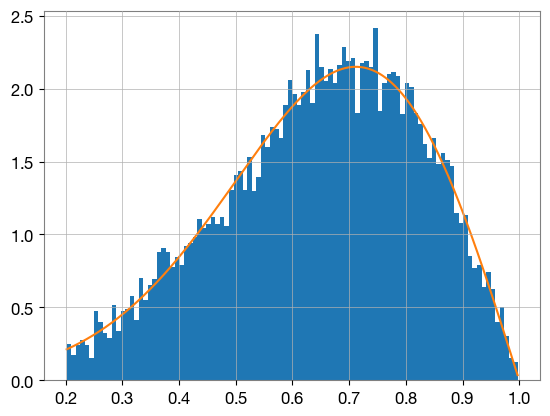

In [30]:
from ler.lens_galaxy_population.sampler_functions import axis_ratio_rayleigh_rvs, axis_ratio_rayleigh_pdf
import numpy as np
import matplotlib.pyplot as plt

q_samples = axis_ratio_rayleigh_rvs(10000, 161.0*np.ones(10000))
q_samples = np.sort(q_samples)
q_pdf = axis_ratio_rayleigh_pdf(q_samples, 161.0*np.ones(10000))


plt.hist(q_samples, bins=100, density=True)
plt.plot(q_samples, q_pdf)
plt.show()

/var/folders/ws/0948zvwd7g795j2l3fryghjw0000gp/T/ipykernel_32795/1659797916.py:36: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  sigma_pdf = sigma_pdf / np.trapz(sigma_pdf, sigma_array)


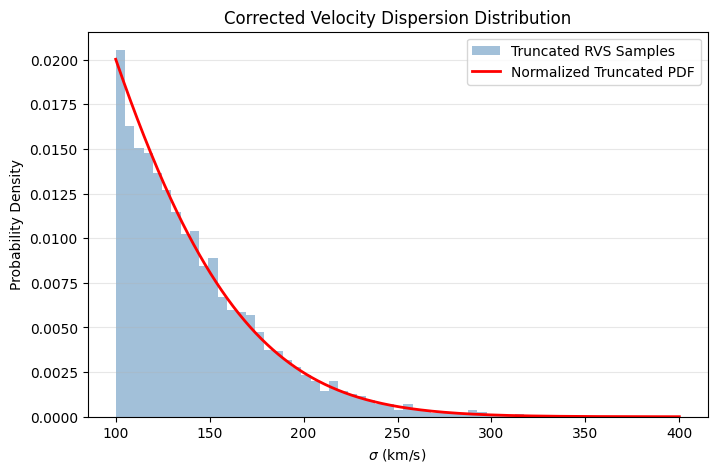

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gengamma
from astropy.cosmology import LambdaCDM

cosmo = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7)

# 1. Define physical parameters
alpha = 0.94
beta = 1.85
sigmastar = 113.78
a, c = alpha / beta, beta

# Define the truncation range
lower_bound = 100
upper_bound = 400

def truncated_gengamma_rvs(a, c, loc, scale, lower_bound, upper_bound, size):
    total_samples = []
    while len(total_samples) < size:
        # Match the PDF scaling: loc=0, scale=sigmastar
        batch = gengamma.rvs(a, c, loc=loc, scale=scale, size=size * 2)
        # Filter samples to fall strictly within [lower_bound, upper_bound]
        valid = batch[(batch >= lower_bound) & (batch <= upper_bound)]
        total_samples.extend(valid)
        
    return np.array(total_samples[:size])

# 2. Generate the PDF for visualization
sigma_array = np.linspace(lower_bound, upper_bound, 500)
# Note: To match scipy's internal logic, use the scale parameter properly
sigma_pdf = gengamma.pdf(sigma_array, a=a, c=c, loc=0, scale=sigmastar)

# Normalize PDF specifically over the [100, 400] range
# This ensures the area under the curve in the plot is 1
sigma_pdf = sigma_pdf / np.trapz(sigma_pdf, sigma_array)

# 3. Generate 5,000 random samples
sigma_samples = truncated_gengamma_rvs(a, c, loc=0, scale=sigmastar, 
                                       lower_bound=lower_bound, 
                                       upper_bound=upper_bound, 
                                       size=5000)

# 4. Visualization
plt.figure(figsize=(8, 5))

# Plot the histogram
plt.hist(sigma_samples, bins=50, density=True, alpha=0.5, 
         color='steelblue', label='Truncated RVS Samples')

# Plot the PDF
plt.plot(sigma_array, sigma_pdf, 'r-', lw=2, label='Normalized Truncated PDF')

plt.title(f'Corrected Velocity Dispersion Distribution')
plt.xlabel(r'$\sigma$ (km/s)')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

optical_depth_sis_analytic interpolator will be loaded from ./interpolator_json/optical_depth/optical_depth_sis_analytic_6.json


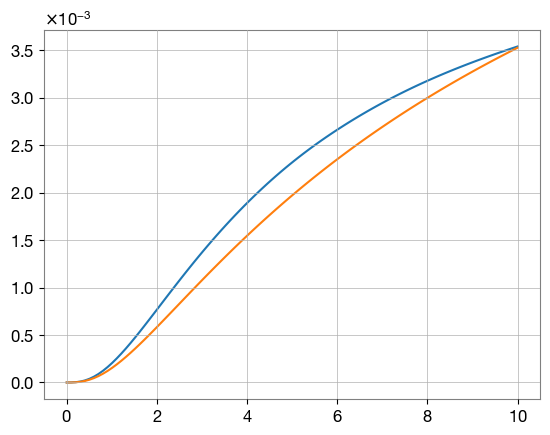

In [4]:
import numpy as np 

zs = np.linspace(0.001, 10, 100)
tau_sie = ler.optical_depth(zs)
tau_sis = ler.optical_depth_sis_analytic(zs)

import matplotlib.pyplot as plt

plt.plot(zs, tau_sie)
plt.plot(zs, tau_sis)
plt.show()

In [3]:
lens_param = ler.sample_lens_parameters(10000)

sampling lens parameters with sample_all_routine_epl_shear_sl...


Importance sampling: 100%|██████████████████████████████████| 10000/10000 [00:07<00:00, 1364.54it/s]


In [2]:
from ler.lens_galaxy_population import LensGalaxyParameterDistribution

ler = LensGalaxyParameterDistribution(
    npool=6,
    lens_type="sie_galaxy",
    lens_param_samplers=dict(
        lens_redshift="lens_redshift_strongly_lensed_numerical",
        axis_ratio=q_object,
    ),
    lens_param_samplers_params=dict(
        lens_redshift=dict(integration_size=25000, use_multiprocessing=False),
        axis_ratio=axis_ratio_args,
    ),
    create_new_interpolator=dict(
        lens_redshift=dict(create_new=True, resolution=48, zl_resolution=48)
    ),
)


Initializing LensGalaxyParameterDistribution class...


Initializing OpticalDepth class

comoving_distance interpolator will be loaded from ./interpolator_json/comoving_distance/comoving_distance_0.json
angular_diameter_distance interpolator will be loaded from ./interpolator_json/angular_diameter_distance/angular_diameter_distance_0.json
angular_diameter_distance interpolator will be loaded from ./interpolator_json/angular_diameter_distance/angular_diameter_distance_0.json
differential_comoving_volume interpolator will be loaded from ./interpolator_json/differential_comoving_volume/differential_comoving_volume_0.json
using ler available velocity dispersion function : velocity_dispersion_ewoud
velocity_dispersion_ewoud interpolator will be loaded from ./interpolator_json/velocity_dispersion/velocity_dispersion_ewoud_0.json
using user provided custom axis_ratio class/object of type ler.utils.FunctionConditioning
using ler available axis_rotation_angle function : axis_rotation_angle_uni

100%|███████████████████████████████████████████████████████████████| 48/48 [01:06<00:00,  1.39s/it]


lens_redshift_strongly_lensed_numerical_sie_galaxy interpolator will be generated at ./interpolator_json/lens_redshift/lens_redshift_strongly_lensed_numerical_sie_galaxy_5.json
lens_redshift_intrinsic interpolator will be loaded from ./interpolator_json/lens_redshift_intrinsic/lens_redshift_intrinsic_0.json
using ler available density_profile_slope_sl function : density_profile_slope_normal
using ler available external_shear_sl function : external_shear_normal
using ler available optical depth function : optical_depth_numerical
optical_depth_numerical interpolator will be generated at ./interpolator_json/optical_depth/optical_depth_numerical_11.json

Initializing CBCSourceRedshiftDistribution class...

luminosity_distance interpolator will be loaded from ./interpolator_json/luminosity_distance/luminosity_distance_0.json
differential_comoving_volume interpolator will be loaded from ./interpolator_json/differential_comoving_volume/differential_comoving_volume_0.json
using ler available m

In [1]:
from scipy.interpolate import CubicSpline  # noqa: E402
from ler.utils import FunctionConditioning
import numpy as np

axis_ratio_args = dict(
    q_min=0.2,
    q_max=1.0,
)

identifier_dict = {"name": "axis_ratio_padilla_strauss_custom"}
identifier_dict["q_min"] = axis_ratio_args["q_min"]
identifier_dict["q_max"] = axis_ratio_args["q_max"]

# Using Padilla and Strauss 2008 distribution for axis ratio
q_array = np.array(
    [0.04903276402927845,0.09210526315789469,0.13596491228070173,0.20789473684210524,0.2899703729522482,0.3230132450331126,0.35350877192982455,0.37946148483792264,0.4219298245614036,0.4689525967235971,0.5075026141512723,0.5226472638550018,0.5640350877192983,0.6096491228070177,0.6500000000000001,0.6864848379226213,0.7377192982456142,0.7787295224817011,0.8007581038689441,0.822786685256187,0.8668438480306729,0.8973684210526317,0.9254385964912283,
    ]
)
pdf = np.array(
    [0.04185262687135349,0.06114520695141845,0.096997499638376,0.1932510900336828,0.39547914337673706,0.49569751276216234,0.6154609137685201,0.7182049959882812,0.920153741243567,1.1573982157399754,1.3353263628106684,1.413149656448315,1.5790713532948977,1.7280185150744938,1.8132994441344819,1.8365803753840484,1.8178662203211204,1.748929843583365,1.688182592496342,1.6274353414093188,1.4948487090314488,1.402785526832393,1.321844068356993,
    ]
)

# Inverse 
cdf_values = np.cumsum(pdf)
cdf_values = cdf_values / cdf_values[-1]
from ler.utils import inverse_transform_sampler
rvs = lambda size: inverse_transform_sampler(size, cdf_values, q_array)

q_object = FunctionConditioning(
    function=None,  # it also allows precomputed values, besides function
    x_array=None,
    conditioned_y_array=None,
    identifier_dict=identifier_dict,
    directory="./interpolator_json",
    sub_directory="axis_ratio",
    name="axis_ratio_padilla_strauss",
    create_new=False,
    create_function_inverse=False,
    create_function=True,
    create_pdf=True,
    create_rvs=rvs,
    callback="rvs",
)

In [1]:
from ler.lens_galaxy_population import OpticalDepth

ler = OpticalDepth()


Initializing OpticalDepth class

comoving_distance interpolator will be loaded from ./interpolator_json/comoving_distance/comoving_distance_0.json
angular_diameter_distance interpolator will be loaded from ./interpolator_json/angular_diameter_distance/angular_diameter_distance_0.json
angular_diameter_distance interpolator will be loaded from ./interpolator_json/angular_diameter_distance/angular_diameter_distance_0.json
differential_comoving_volume interpolator will be loaded from ./interpolator_json/differential_comoving_volume/differential_comoving_volume_0.json
using ler available velocity dispersion function : velocity_dispersion_ewoud
velocity_dispersion_ewoud interpolator will be loaded from ./interpolator_json/velocity_dispersion/velocity_dispersion_ewoud_0.json
using ler available axis_ratio function : axis_ratio_rayleigh
axis_ratio_rayleigh interpolator will be loaded from ./interpolator_json/axis_ratio/axis_ratio_rayleigh_0.json
using ler available axis_rotation_angle functio

100%|██████████████████████████████████████████████████| 6328125/6328125 [2:37:40<00:00, 668.89it/s]


using ler available lens_redshift function : lens_redshift_strongly_lensed_numerical
Numerically solving the lens redshift distribution...
Checking if the function can be JIT compiled
Using multithreaded njit
lens_redshift_strongly_lensed_numerical_epl_shear_galaxy interpolator will be generated at ./interpolator_json/lens_redshift/lens_redshift_strongly_lensed_numerical_epl_shear_galaxy_3.json
lens_redshift_intrinsic interpolator will be loaded from ./interpolator_json/lens_redshift_intrinsic/lens_redshift_intrinsic_0.json
using ler available density_profile_slope_sl function : density_profile_slope_normal
using ler available external_shear_sl function : external_shear_normal
using ler available optical depth function : optical_depth_numerical
optical_depth_numerical interpolator will be loaded from ./interpolator_json/optical_depth/optical_depth_numerical_0.json


In [37]:
from gwsnr.numba import findchirp_chirptime

findchirp_chirptime(m1=23, m2=2.6, fmin=20)

10.300932654900821